In [1]:
import pandas as pd
import numpy as np 
import os
import glob
from tqdm import tqdm
from tools import get_daily_data, Factor_Analysis, factor_backtest
                    
                    
# 目前2020-2025日频数据全部支持，分钟频数据需要自己写。
# 注意事项：
# 1. factor_analysis传入函数的数据保持['stock_code','date','factor_value']，顺序不要错                
# 2. stock_code和exchange分开


正在进行MAD去极值...


正在进行中性化: 100%|██████████| 969/969 [03:37<00:00,  4.45it/s]


正在进行标准化...


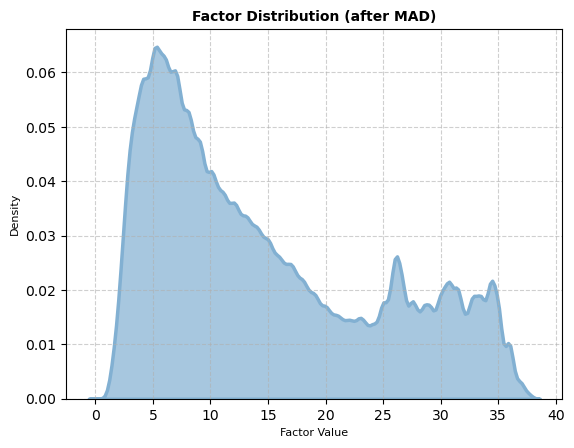

In [35]:
# Step1: 股票池筛选（剔除上市不足一年的股票，剔除停牌股票)
daily_df = get_daily_data('2021-01-01','2025-01-01')
factor_df = daily_df[['stock_code','date','open','close','high','low','volume','money','mcap']].copy()
factor_df = Factor_Analysis(factor_df, factor_name = 'open')

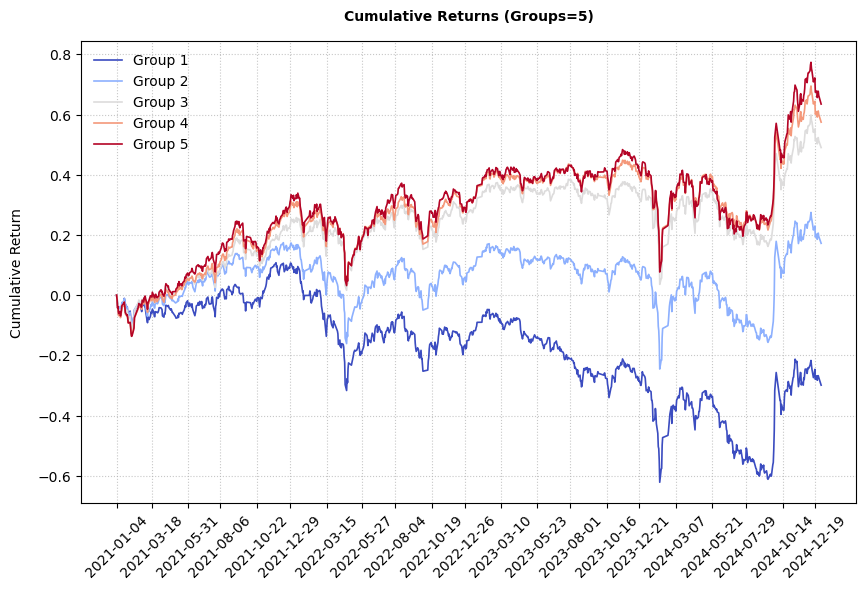

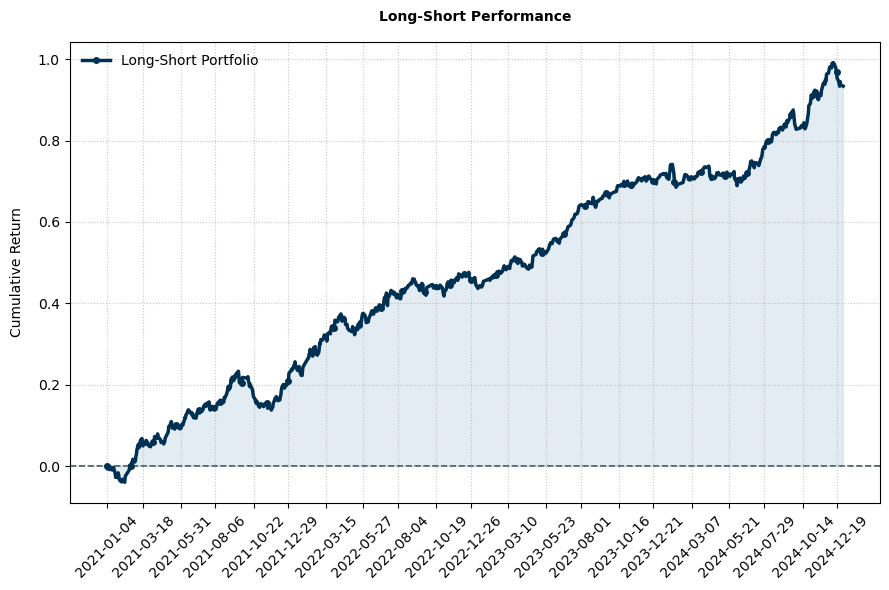

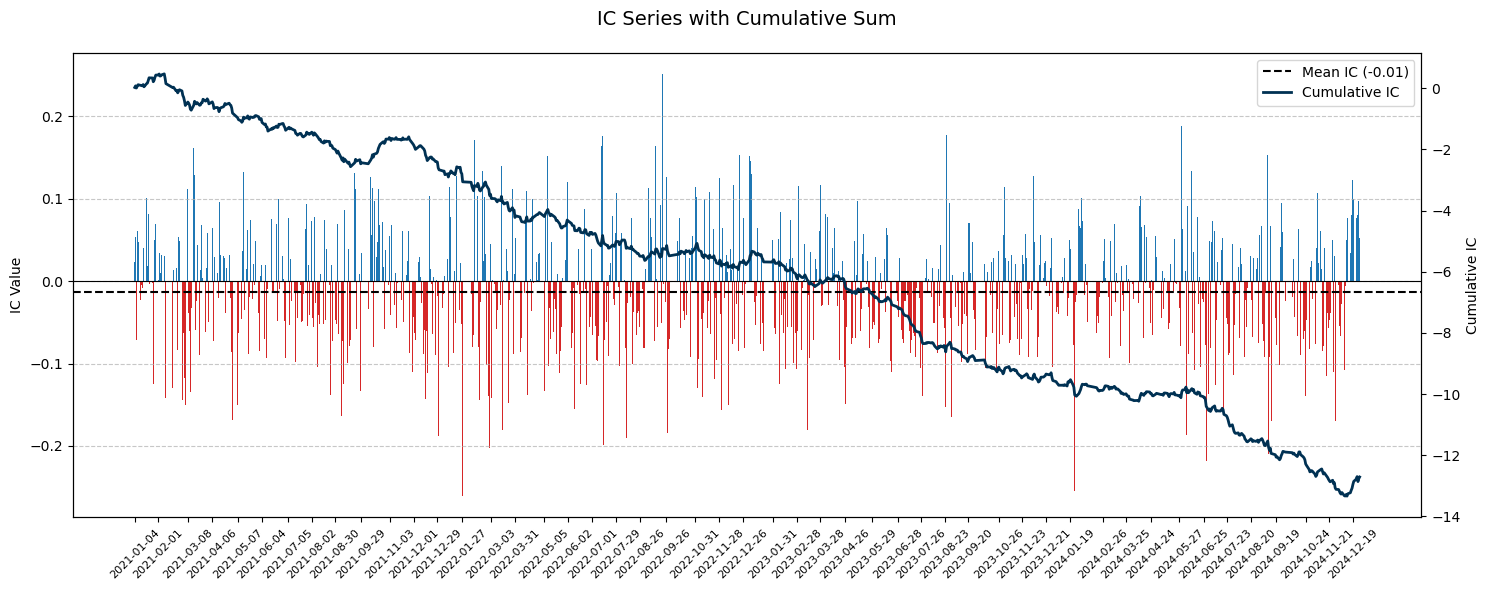

In [37]:
# Step7: 分组收益图绘制，注意组号5为多头组，组号1为空头组
result, group_returns, ic = factor_backtest(factor_df,
                         factor_name = 'open',
                         start_date='2021-01-01',
                         end_date='2025-01-01', 
                         lag_days = 2, 
                         direction = -1,
                         group = 5,
                         plot = True)

In [33]:
result

,IC均值,IC标准差,ICIR,多头年化收益(%),空头年化收益(%),多空最大回撤(%),夏普比率,总期数,正IC期数,正IC期数占比,正IC均值,正IC波动率,负IC期数占比,负IC均值,负IC波动率
value,-0.01,0.08,-0.15,-1.79,NaN,inf,-204.52,967,416,43.02%,0.0581,4.60%,56.98%,-0.0648,5.07%


In [32]:
group_returns.cumsum() / group_returns.std()

,5,4,3,2,1,long_short
date,,,,,,
2021-01-04,-0.618192,-0.717703,-0.947118,-0.922371,-0.444192,-0.165988
2021-01-05,-2.378971,-2.480991,-2.726916,-2.709713,-1.097392,-1.522460
2021-01-06,-2.225341,-2.516616,-2.731727,-2.611614,-1.424886,-0.848912
2021-01-07,-3.930064,-4.204206,-4.250695,-3.766065,-2.245969,-1.889750
2021-01-08,-3.777760,-3.755789,-3.815435,-3.249207,-1.274561,-3.093535
...,...,...,...,...,...,...
2024-12-23,63.294524,44.514185,33.264328,9.705324,-29.431825,125.165923
2024-12-24,63.611053,45.169721,33.998760,10.577698,-28.361963,124.034456
2024-12-25,64.737399,46.124831,34.491111,10.671715,-28.652451,125.924998


In [ ]:
# Step8: 策略结果
group_returns[1].sum()


In [34]:
# Step12: 策略绩效
def performance_detail(returns_df:pd.DataFrame):
    """
    生成分组绩效分析表格
    
    参数：
    returns_df : DataFrame - 列名为分组编号(1-10)，索引为日期的累计收益率数据
    annualized_factor : int - 年化因子(默认252, 日频数据)
    
    返回：
    performance_df : DataFrame - 绩效分析表格
    """
    performance = []
    
    for group in returns_df.columns:
        ret_series = returns_df[group].dropna()
        
        # 基础统计
        total_periods = len(ret_series)
        mean_return = ret_series.mean()
        volatility = ret_series.std() 
        
        # 正收益统计
        positive_ret = ret_series[ret_series > 0]
        positive_count = len(positive_ret)
        positive_ratio = positive_count / total_periods
        positive_mean = positive_ret.mean() if positive_count > 0 else np.nan
        positive_vol = positive_ret.std() if positive_count > 1 else np.nan
        
        # 负收益统计
        negative_ret = ret_series[ret_series < 0]
        negative_count = len(negative_ret)
        negative_mean = negative_ret.mean() if negative_count > 0 else np.nan
        negative_vol = negative_ret.std() if negative_count > 1 else np.nan
        
        performance.append({
            'Group': group,
            '总期数': total_periods,
            '收益均值': mean_return,
            '收益波动率': volatility,
            '正收益期数': positive_count,
            '正收益期数占比': positive_ratio,
            '正收益均值': positive_mean,
            '正收益波动率': positive_vol,
            '负收益均值': negative_mean,
            '负收益波动率': negative_vol
        })
    
    # 创建DataFrame
    performance_df = pd.DataFrame(performance).set_index('Group')
    
    # 格式化百分比
    percent_cols = ['收益均值', '收益波动率', '正收益期数占比', 
                   '正收益均值', '正收益波动率',
                   '负收益均值', '负收益波动率']
    
    for col in percent_cols:
        performance_df[col] = performance_df[col].apply(
            lambda x: f"{x:.2%}" if not pd.isna(x) else "N/A"
        )
    
    # 重命名列与示例对齐
    performance_df = performance_df.rename(columns={
        '正收益期数占比': '正收益期数占比',
        '适宜收益波动率': '适宜收益波动率'
    })
    
    return performance_df

result_table = performance_detail(group_returns)
result_table

,总期数,收益均值,收益波动率,正收益期数,正收益期数占比,正收益均值,正收益波动率,负收益均值,负收益波动率
Group,,,,,,,,,
5,241,0.16%,1.07%,139,57.68%,0.87%,0.64%,-0.82%,0.70%
4,241,0.13%,1.06%,143,59.34%,0.82%,0.58%,-0.89%,0.71%
3,241,0.10%,1.08%,139,57.68%,0.83%,0.61%,-0.89%,0.71%
2,241,0.08%,1.11%,135,56.02%,0.84%,0.66%,-0.89%,0.74%
1,241,0.03%,1.23%,128,53.11%,0.94%,0.75%,-1.01%,0.76%
long_short,241,0.13%,1.27%,130,53.94%,1.08%,0.83%,-0.97%,0.66%


In [41]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
from IPython.display import display
import plotly.io as pio

# 设置 Plotly 渲染器（适配不同环境，如 Jupyter 或脚本）
pio.renderers.default = 'browser'  # 浏览器显示，VS Code 可改为 'vscode'

# 初始化数据
np.random.seed(42)
n_points = 100
dates = pd.date_range(start='2025-01-01', periods=n_points, freq='D')
close_prices = np.random.normal(100, 10, n_points).cumsum()  # 模拟收盘价
returns = np.random.normal(0, 0.02, n_points)  # 模拟下一日收益
data = pd.DataFrame({'close': close_prices, 'next_day_return': returns}, index=dates)

# 计算因子（5日动量）
data['momentum'] = data['close'].pct_change(5)

# 计算IC函数
def calculate_ic(df, factor, return_col):
    return df[[factor, return_col]].corr().iloc[0, 1]

# 初始化图表
fig = go.Figure()
fig.add_trace(go.Scatter(x=[], y=[], mode='lines', name='IC (Momentum vs Next Day Return)',
                         hovertemplate='Time: %{x}<br>IC: %{y:.4f}<extra></extra>'))
fig.update_layout(
    title='Real-Time IC Plot (Zoomable & Hoverable)',
    xaxis_title='Time Step',
    yaxis_title='IC Value',
    showlegend=True,
    template='plotly_dark',  # 可改为 'plotly' 用于亮色主题
    hovermode='x unified'
)
fig.update_xaxes(rangeslider_visible=True)  # 添加缩放滑块

# 存储数据
ic_values = []
time_steps = []

# 更新函数
def update_plot():
    global data, ic_values, time_steps
    
    # 模拟实时数据：添加新数据点
    new_date = data.index[-1] + pd.Timedelta(days=1)
    new_close = data['close'].iloc[-1] + np.random.normal(0, 10)
    new_return = np.random.normal(0, 0.02)
    new_row = pd.DataFrame({'close': [new_close], 'next_day_return': [new_return]}, index=[new_date])
    data = pd.concat([data, new_row])
    
    # 更新动量因子
    data['momentum'] = data['close'].pct_change(5)
    
    # 计算最新IC（用最近20天数据）
    ic = calculate_ic(data.tail(20), 'momentum', 'next_day_return')
    ic_values.append(ic)
    time_steps.append(len(time_steps))
    
    # 更新图表
    fig.data[0].x = time_steps
    fig.data[0].y = ic_values
    
    # 保存或显示（视环境而定）
    fig.write_html('realtime_ic_plot.html')  # 保存为交互式HTML
    # 如果在Jupyter中，取消注释以下行以显示
    # display(fig)

# 模拟实时更新（每秒更新一次，运行10次）
for _ in range(10):
    update_plot()
    time.sleep(1)

# 保存最终图表
fig.write_html('realtime_ic_plot.html')